In [1]:
import IPython
import json

In [2]:
from diffusers import DiffusionPipeline
import torch
import os

# 設定環境變數，避免內存碎片化
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# 半精度模型可以減少內存使用，加速運算。然後我們將模型放到GPU上。use_safetensors代表使用一種Hugging Face的模型參數儲存檔案，替代傳統的 PyTorch .pt 或 .bin 文件格式，更安全。
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True, torch_dtype=torch.float16).to("cuda")
print(pipeline.to_json_string())

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



## Stable Diffusion Pipeline 組件說明
圖片的feature_extractor使用transformers模組底下的CLIPImageProcessor class，以此類推。
### JSON 結構：
```json
{
    "feature_extractor": ["transformers.CLIPImageProcessor"],
    "image_encoder": [null, null],
    "requires_safety_checker": true,
    "safety_checker": ["stable_diffusion.StableDiffusionSafetyChecker"],
    "scheduler": ["diffusers.PNDMScheduler"],
    "text_encoder": ["transformers.CLIPTextModel"],
    "tokenizer": ["transformers.CLIPTokenizer"],
    "unet": ["diffusers.UNet2DConditionModel"],
    "vae": ["diffusers.AutoencoderKL"]
}

## Prompt to the pipeline to generate an image.
and then access the denoised image. By default, the image output is wrapped in a PIL.Image object.

In [3]:
# 啟用內存優化功能
pipeline.enable_model_cpu_offload()
pipeline.enable_xformers_memory_efficient_attention()
image = pipeline("An image of a squirrel in Picasso style")
print(image)

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x251A37FE890>], nsfw_content_detected=[False])


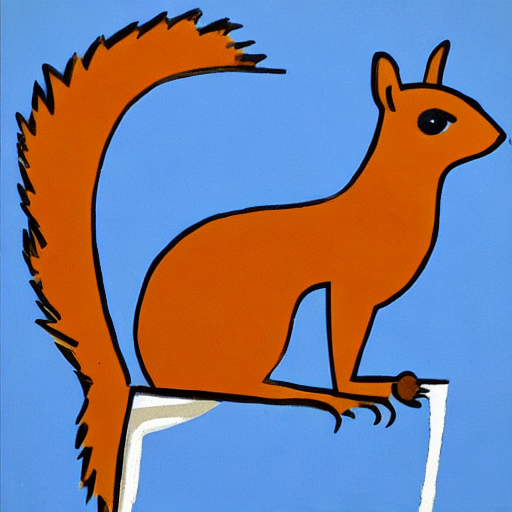

In [4]:
image.get("images")[0]

In [5]:
# 存檔生成的圖片
image.get("images")[0].save("image_of_squirrel_painting.png")

## Local pipeline

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x251A3CD90D0>], nsfw_content_detected=[False])


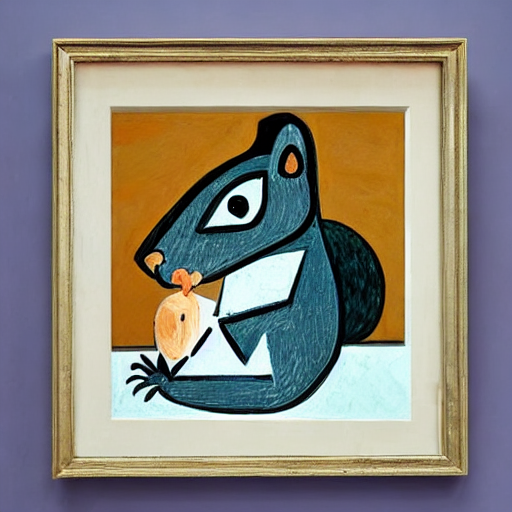

In [6]:
# 在終端機尋找huggingface下載路徑
# conda env: (inpaint) 下使用 huggingface-cli scan-cache
pipeline_local = DiffusionPipeline.from_pretrained("C:/Users/lab/.cache/huggingface/hub/models--stable-diffusion-v1-5--stable-diffusion-v1-5/snapshots/f03de327dd89b501a01da37fc5240cf4fdba85a1", use_safetensors=True, torch_dtype=torch.float16).to("cuda")
# 啟用內存優化功能
pipeline_local.enable_model_cpu_offload()
pipeline_local.enable_xformers_memory_efficient_attention()
image_local = pipeline_local("An image of a squirrel in Picasso style")
print(image_local)
IPython.display.display(image_local.get("images")[0])
image_local.get("images")[0].save("image_of_squirrel_painting_local.png")

## Swapping schedulers 使用不同的schedulers
Different schedulers come with different denoising speeds and quality trade-offs. The best way to find out which one works best for you is to try them out! One of the main features of 🧨 Diffusers is to allow you to easily switch between schedulers. For example, to replace the default PNDMScheduler with the EulerDiscreteScheduler, load it with the from_config() method:

In [7]:
from diffusers import EulerDiscreteScheduler
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True, torch_dtype=torch.float16).to("cuda")
pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x2519791AED0>], nsfw_content_detected=[False])


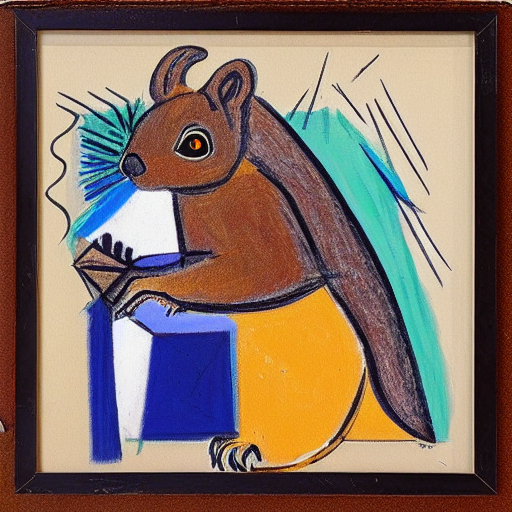

In [8]:
# 啟用內存優化功能
pipeline.enable_model_cpu_offload()
pipeline.enable_xformers_memory_efficient_attention()
image = pipeline("An image of a squirrel in Picasso style")
print(image)
IPython.display.display(image.get("images")[0])
image.get("images")[0].save("image_of_squirrel_painting_euler.png")

### 使用另一個Scheduler

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x251D4C15650>], nsfw_content_detected=[False])


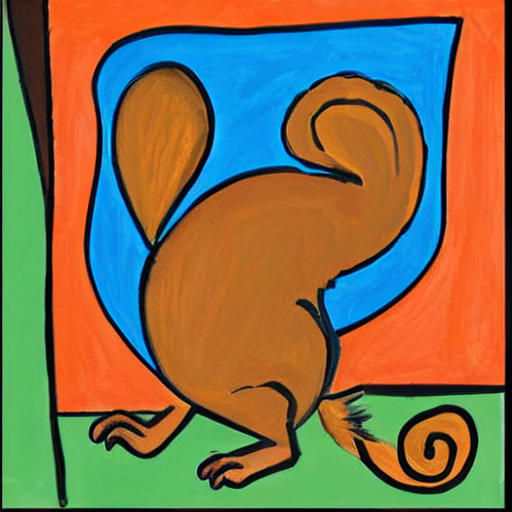

In [9]:
# 使用DPMSolverMultistepScheduler
from diffusers import DPMSolverMultistepScheduler
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True, torch_dtype=torch.float16).to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler().from_config(pipeline.scheduler.config, use_karras_sigmas=True)

# 啟用內存優化功能
pipeline.enable_model_cpu_offload()
pipeline.enable_xformers_memory_efficient_attention()
image = pipeline("An image of a squirrel in Picasso style")
print(image)
IPython.display.display(image.get("images")[0])
image.get("images")[0].save("image_of_squirrel_painting_dpm.png")

# A example of unconditional image generation

## Models
Each timestep it predicts the **noise residual** (other models learn to predict the previous sample directly or the velocity or v-prediction), the difference between a less noisy image and the input image. You can mix and match models to create other diffusion systems.

For the quicktour, you’ll load the **UNet2DModel**, a basic unconditional image generation model with a checkpoint trained on **cat images**:

In [13]:
import IPython
from diffusers import UNet2DModel
repo_id = "google/ddpm-cat-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=True).to("cuda")
IPython.display.display(model.config)

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

**model.config不能被改變!**

The model configuration is a 🧊 frozen 🧊 dictionary, which means those parameters can’t be changed after the model is created. This is intentional and ensures that the parameters used to define the model architecture at the start remain the same, while other parameters can still be adjusted during inference.

Some of the most important parameters are:
- sample_size: the height and width dimension of the input sample.
- in_channels: the number of input channels of the input sample.
- down_block_types and up_block_types: the type of down- and upsampling blocks used to create the UNet architecture.
- block_out_channels: the number of output channels of the downsampling blocks; also used in reverse order for the number of input channels of the upsampling blocks.
- layers_per_block: the number of ResNet blocks present in each UNet block.

In [14]:
# create the image shape with random Gaussian noise
import torch
# 使用固定隨機種子，確保每次生成的隨機數相同，保證可重現性。生成的值是從均值為0，標準差為1的正態分佈中隨機取樣，範圍為(-∞, ∞)。
torch.manual_seed(0)
noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size).to("cuda")
noisy_sample.shape

torch.Size([1, 3, 256, 256])

### Inference
- pass `(noisy image, timestep)` to the model
- The `timestep` indicates how noisy the input image is, with more noise at the beginning and less at the end. This helps the model determine its position in the diffusion process, whether it is closer to the start or the end.
- Use the `sample` method to get the model output:
- 較大的 timestep 表示更多噪聲，較小的 timestep 表示更接近清晰圖像。**表示多次去噪過程中的倒數第幾步。**(口語，不一定是線性)

In [ ]:
# float32 轉換為 float16，如果model和sample都是float16，會生成看不出是貓的圖片。
# noisy_sample = noisy_sample.half()
with torch.no_grad():
    # 進行推理，生成噪聲預測。在當前時間步數時（timestep=2）對輸入樣本（noisy_sample）中噪聲的預測。
    noisy_residual = model(sample=noisy_sample, timestep=2)

## Schedulers
Schedulers manage going from a noisy sample to a less noisy sample given the model output - in this case, it is the `noisy_residual`.

>🧨 Diffusers is a toolbox for building diffusion systems. While the DiffusionPipeline is a convenient way to get started with a pre-built diffusion system, you can also choose your own model and scheduler components separately to build a custom diffusion system.

For the quicktour, you’ll instantiate the DDPMScheduler with its from_config() method:

In [16]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler.from_pretrained(repo_id)
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

> 💡 Unlike a model, a scheduler does not have trainable weights and is parameter-free!

Some of the most important parameters are:

- `num_train_timesteps`: the length of the denoising process or, in other words, **the number of timesteps required to process random Gaussian noise into a data sample**.
- `beta_schedule`: the type of noise schedule to use for inference and training.
- `beta_start` and `beta_end`: the start and end noise values for the noise schedule.
To predict a slightly less noisy image, pass the following to the scheduler’s step() method: model output, timestep, and current sample.

In [17]:
less_noisy_sample = scheduler.step(model_output=noisy_residual.sample, timestep=2, sample=noisy_sample).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

The less_noisy_sample can be passed to the next timestep where it’ll get even less noisy! Let’s bring it all together now and visualize the entire denoising process.

First, create a function that postprocesses and displays the denoised image as a PIL.Image:

In [18]:
# 定義顯示圖片的函數
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [19]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

In [25]:
print("Scheduler timesteps:", scheduler.config.num_train_timesteps)  # 應該是 1000

Scheduler timesteps: 1000


### Predicts the residual
Predicts the residual of the less noisy sample, and computes the less noisy sample with the scheduler:

Pixel range: tensor(-4.3433, device='cuda:0') tensor(4.6582, device='cuda:0')


  5%|▍         | 48/1000 [00:03<01:08, 13.98it/s]

'Image at step 50'

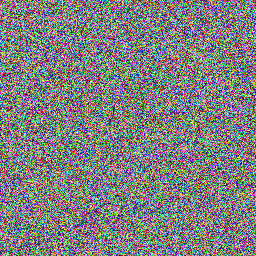

 10%|▉         | 99/1000 [00:07<01:03, 14.22it/s]

'Image at step 100'

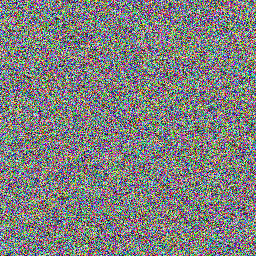

 15%|█▍        | 149/1000 [00:10<01:00, 14.06it/s]

'Image at step 150'

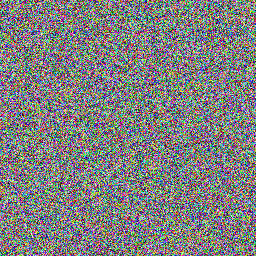

 20%|█▉        | 199/1000 [00:14<00:56, 14.10it/s]

'Image at step 200'

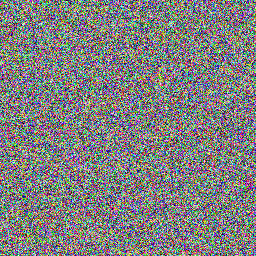

 25%|██▍       | 249/1000 [00:18<00:53, 14.11it/s]

'Image at step 250'

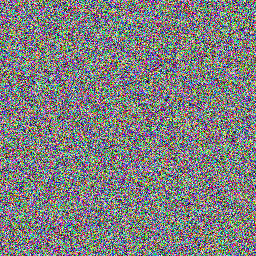

 30%|██▉       | 299/1000 [00:21<00:49, 14.14it/s]

'Image at step 300'

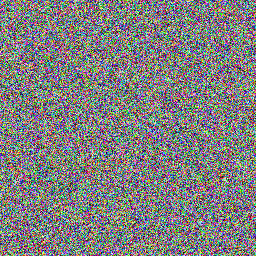

 35%|███▍      | 349/1000 [00:25<00:45, 14.26it/s]

'Image at step 350'

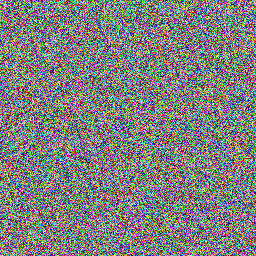

 40%|███▉      | 399/1000 [00:28<00:42, 14.05it/s]

'Image at step 400'

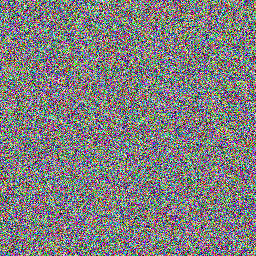

 45%|████▍     | 449/1000 [00:32<00:39, 14.12it/s]

'Image at step 450'

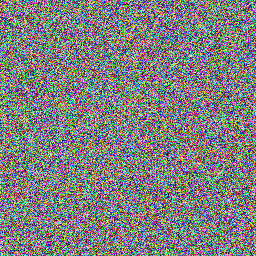

 50%|████▉     | 499/1000 [00:35<00:35, 14.07it/s]

'Image at step 500'

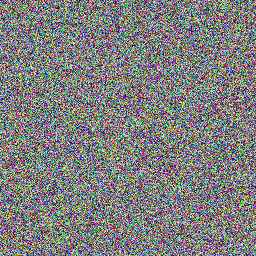

 55%|█████▍    | 549/1000 [00:39<00:32, 14.03it/s]

'Image at step 550'

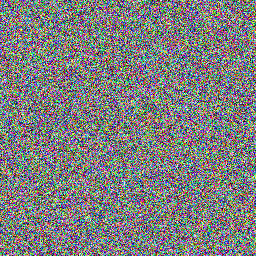

 60%|█████▉    | 599/1000 [00:43<00:28, 14.20it/s]

'Image at step 600'

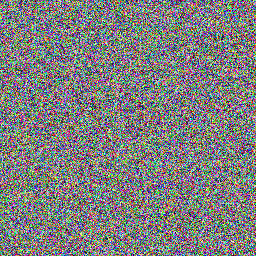

 65%|██████▍   | 649/1000 [00:46<00:25, 14.00it/s]

'Image at step 650'

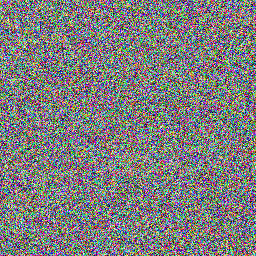

 70%|██████▉   | 699/1000 [00:50<00:21, 14.05it/s]

'Image at step 700'

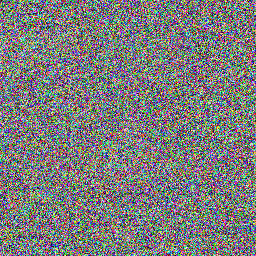

 75%|███████▍  | 749/1000 [00:53<00:17, 14.17it/s]

'Image at step 750'

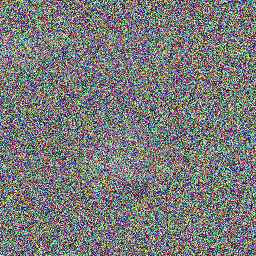

 80%|███████▉  | 799/1000 [00:57<00:15, 13.27it/s]

'Image at step 800'

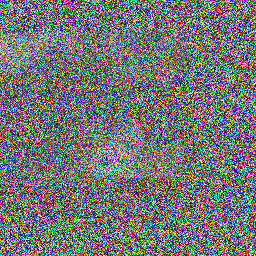

 85%|████████▍ | 849/1000 [01:00<00:10, 13.99it/s]

'Image at step 850'

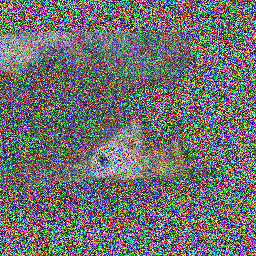

 90%|████████▉ | 899/1000 [01:04<00:07, 14.12it/s]

'Image at step 900'

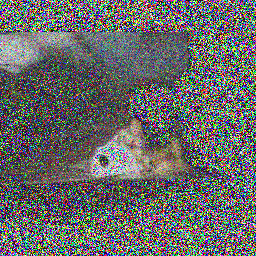

 95%|█████████▍| 949/1000 [01:08<00:03, 14.06it/s]

'Image at step 950'

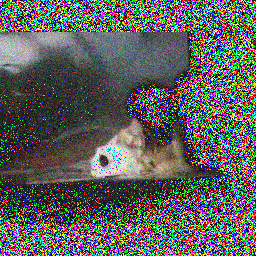

100%|█████████▉| 999/1000 [01:11<00:00, 13.82it/s]

'Image at step 1000'

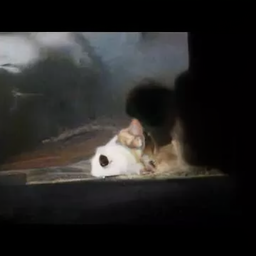

100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]


In [27]:
import tqdm

sample = noisy_sample
print("Pixel range:", sample.min(), sample.max())
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 50 == 0:
        display_sample(sample, i + 1)